<a href="https://colab.research.google.com/github/EndymionSleeping/1KB570-project/blob/main/matb_project_v3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init
Handling dependancied and importing datasets

In [1]:
from google.colab import output
output.enable_custom_widget_manager()


In [2]:
try:
    import google.colab  # type: ignore # noqa: F401
    %pip install git+https://github.com/hackingmaterials/matbench
except ImportError:
    print("not in Colab")

  Cloning https://github.com/hackingmaterials/matbench to /tmp/pip-req-build-nqogd3ub
  Running command git clone --filter=blob:none --quiet https://github.com/hackingmaterials/matbench /tmp/pip-req-build-nqogd3ub
  Resolved https://github.com/hackingmaterials/matbench to commit 936176db18ca4cd7b38cbd957c017a5bac770c6b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 22.0 MB/s eta 0:00

In [3]:
from matbench.bench import MatbenchBenchmark
mb = MatbenchBenchmark(autoload=False)

2024-10-14 08:00:38 INFO     Initialized benchmark 'matbench_v0.1' with 13 tasks: 
['matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels']


INFO:matbench:Initialized benchmark 'matbench_v0.1' with 13 tasks: 
['matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels']


In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


# Get first task

In [37]:
for task in mb.tasks:
    if task.dataset_name == "matbench_dielectric":
      print(task.dataset_name)
      break

mb.matbench_dielectric.load()

for fold in task.folds:

      # Inputs are either chemical compositions as strings
      # or crystal structures as pymatgen.Structure objects.
      # Outputs are either floats (regression tasks) or bools (classification tasks)
      train_inputs, train_outputs = task.get_train_and_val_data(fold)

matbench_dielectric
2024-10-14 08:33:13 INFO     Dataset matbench_dielectric already loaded; not reloading dataset.


INFO:matbench.task:Dataset matbench_dielectric already loaded; not reloading dataset.


# Prepare the data

In [6]:
train_inputs[len(train_inputs)-1]

<ipython-input-6-a498127e76ac>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_inputs[len(train_inputs)-1]


Structure Summary
Lattice
    abc : 5.61279281 5.61279281 5.61279281
 angles : 90.0 90.0 90.0
 volume : 176.82229907901328
      A : 5.61279281 0.0 0.0
      B : 0.0 5.61279281 0.0
      C : 0.0 0.0 5.61279281
    pbc : True True True
PeriodicSite: Cs (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Ge (2.806, 2.806, 2.806) [0.5, 0.5, 0.5]
PeriodicSite: Br (2.806, 2.806, 0.0) [0.5, 0.5, 0.0]
PeriodicSite: Br (2.806, 0.0, 2.806) [0.5, 0.0, 0.5]
PeriodicSite: Br (0.0, 2.806, 2.806) [0.0, 0.5, 0.5]

In [42]:
def extract_features(structure_data):
    lattice_params = structure_data.lattice.abc
    angles = structure_data.lattice.angles
    volume = structure_data.lattice.volume

    # Extract atomic coordinates and species
    atomic_coords = [site.frac_coords for site in structure_data.sites]
    atomic_species = [site.specie.Z for site in structure_data.sites]

    # Flatten atomic coordinates
    atomic_coords_flat = np.array(atomic_coords).flatten()

    # Ensure both atomic coordinates and species are of length 288
    max_length = 288
    atomic_coords_padded = np.zeros(max_length)
    atomic_species_padded = np.zeros(max_length)

    # Fill in with actual values up to their original lengths
    atomic_coords_padded[:len(atomic_coords_flat)] = atomic_coords_flat[:min(len(atomic_coords_flat), max_length)]
    atomic_species_padded[:len(atomic_species)] = atomic_species[:min(len(atomic_species), max_length)]

    # Concatenate features
    features = np.concatenate([lattice_params, angles, [volume], atomic_coords_padded, atomic_species_padded])

    return features



X = np.array([extract_features(structure) for structure in train_inputs])
y = np.array(train_outputs)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [21]:

"""
def extract_features(structure_data):

    lattice_params = structure_data.lattice.abc
    angles = structure_data.lattice.angles
    volume = structure_data.lattice.volume
    atomic_coords = [site.frac_coords for site in structure_data.sites]
    atomic_species = [site.specie.Z for site in structure_data.sites]

    atomic_coords_flat = np.array(atomic_coords).flatten()
    features = np.concatenate([lattice_params, angles, [volume], atomic_coords_flat, atomic_species])

    lattice_params = structure_data.lattice.abc
    angles = structure_data.lattice.angles
    volume = structure_data.lattice.volume
    atomic_coords = [site.frac_coords for site in structure_data.sites]
    atomic_species = [site.specie.Z for site in structure_data.sites]

    # Flatten atomic coordinates and concatenate features
    #atomic_coords_flat = np.array(atomic_coords).flatten()
    #features = np.concatenate([lattice_params, angles, [volume]])

    features = np.concatenate([lattice_params, angles, [volume], np.array(atomic_coords).flatten()])
    return features









A = [extract_features(structure) for structure in train_inputs]

X = np.array([extract_features(structure) for structure in train_inputs])
y = np.array(train_outputs)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
"""

atomic_coords: 12
atomic_species: 12
atomic_coords: 32
atomic_species: 32
atomic_coords: 36
atomic_species: 36
atomic_coords: 49
atomic_species: 49
atomic_coords: 51
atomic_species: 51
atomic_coords: 56
atomic_species: 56
atomic_coords: 82
atomic_species: 82
atomic_coords: 288
atomic_species: 288


'\nX = np.array([extract_features(structure) for structure in train_inputs])\ny = np.array(train_outputs)\n\n# Scale the data\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# Split the data into train and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n'

In [23]:
X.shape

(3812, 583)

In [35]:
y[0]

1.752063640396657

# ML

In [43]:
def build_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=583))#input_shape=(,7)))
    layers.Dropout(0.2),
    model.add(layers.Dense(128, activation='relu'))
    layers.Dropout(0.3),
    model.add(layers.Dense(64, activation='relu'))
    layers.Dropout(0.1),
    model.add(layers.Dense(1, activation='linear'))
    #model.add(layers.Dense(1))  # Output layer for regression
    print(model.summary())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [44]:
# Build and train the Keras model
model = build_model(X_train.shape[1])


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Get test data and extract features
test_inputs = task.get_test_data(fold, include_target=False)
X_test = np.array([extract_features(structure) for structure in test_inputs])
X_test_scaled = scaler.transform(X_test)

# Predict on the testing data
predictions = model.predict(X_test_scaled)



train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │         149,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,721 (745.00 KB)

 Trainable params: 190,721 (745.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 5.0636 - mae: 1.0489 - val_loss: 5.4113 - val_mae: 0.9203
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 13.1707 - mae: 0.8088 - val_loss: 5.6096 - val_mae: 0.7681
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9073 - mae: 0.8477 - val_loss: 5.2717 - val_mae: 0.6653
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2896 - mae: 0.7999 - val_loss: 5.3541 - val_mae: 0.7609
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6434 - mae: 0.7189 - val_loss: 5.3939 - val_mae: 0.6776
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8260 - mae: 0.7896 - val_loss: 7.6197 - val_mae: 0.8356
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 30.2374 - mae: 0.8840 - val_loss: 6.8882 - val_mae: 0.9114
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6029 - mae: 0.8018 - val_loss: 7.4073 - val_mae: 1.0563
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 66.01

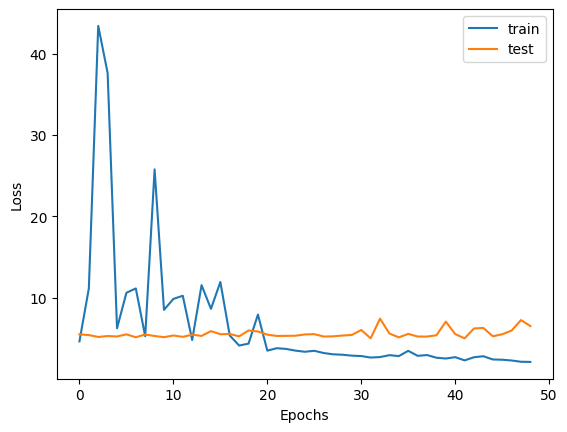

In [29]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()